# **Projeto WaRP - Waste Recycling Plant**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## **⚠️ Observações Importantes:**
**1.** Todas as análises devem ter tratamento de erro, garantindo que o notebook continue rodando mesmo que ocorram problemas como dados faltantes, diretórios incorretos ou arquivos corrompidos.

**2.** Registrar qualquer problema encontrado, como:
- Alto número de imagens corrompidas.
- Desbalanceamento severo nas classes.
- Alto número de duplicatas.

**3.** Documentar a decisão para resolução de probblemas, como:
- Exclução e/ou substituição de imagens corrompidas (porque, quais e quantas).
- Realização de padronização de imagens (porque, quais e quantas).

**4.** Sempre documentar o que foi observado em cada gráfico ou análise.

---

## **Etapa 1 - Análise do Dataset**

### 🧠 Instalação dos pacotes necessários

In [2]:
!pip install opendatasets
!pip install pandas
!pip install imagehash
!pip install matplotlib
!pip install opencv-python
!pip install pillow
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.6 MB/s eta 0:00:00


### 1. Download do Dataset 🚀

In [ ]:
# os arquivos serão salvos na pasta "data" localmente.
# A pasta "data" local foi sincronizada bidirecionalmente com Google Drive

# Configuração das credenciais
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from google.colab import files

# Verificar ou criar a pasta de destino
download_path = '../data' # pasta local

if not os.path.exists(download_path):
    os.makedirs(download_path)
    print(f"Pasta {download_path} criada com sucesso!")

# --- ADDED INSTRUCTION ---
# Upload kaggle.json file
# You need to upload your kaggle.json file. Go to your Kaggle account settings,
# download the kaggle.json file, and upload it here.
print("Por favor, faça upload do arquivo kaggle.json:")
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Ensure the .kaggle directory exists
kaggle_dir = os.path.expanduser('~/.kaggle')
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Save the uploaded file to the correct location
for filename in uploaded.keys():
    with open(os.path.join(kaggle_dir, 'kaggle.json'), 'wb') as f:
        f.write(uploaded[filename])

# Set permissions for the kaggle.json file
os.chmod(os.path.join(kaggle_dir, 'kaggle.json'), 600)
# --- END ADDED INSTRUCTION ---


# Fazer download do dataset
try:
    print("Autenticando com a API do Kaggle...")
    api = KaggleApi()
    api.authenticate()

    print("Iniciando o download do dataset...")
    api.dataset_download_files(
        'parohod/warp-waste-recycling-plant-dataset',
        path=download_path,
        unzip=True
    )

    print("Download concluído com sucesso!")

except Exception as e:
    print(f"Ocorreu um erro durante o download: {e}")

Por favor, faça upload do arquivo kaggle.json:


KeyboardInterrupt: 

### 2. Criação do DataFrame de Metadados 📂

#### Documentação da Criação do DataFrame de Metadados:

✔️ **Objetivo:**
- Gerar um **DataFrame de metadados** com informações detalhadas sobre cada imagem presente no dataset.
- Extrair e armazenar atributos essenciais que serão utilizados nas próximas etapas de análise, validação, limpeza e modelagem.

🏗️ **Informações Coletadas para Cada Imagem:**
- **image_path:** Caminho completo da imagem no sistema de arquivos.
- **corrupted:** Indicação se a imagem está corrompida (True ou False).
- **image_hash:** Hash perceptual (utilizando phash) para detecção de duplicatas.
- **image_format:** Formato da imagem (ex.: JPG, PNG).
- **width:** Largura da imagem (em pixels).
- **height:** Altura da imagem (em pixels).
- **channels:** Quantidade de canais (esperado 3 para imagens RGB).
- **label:** Nome da classe correspondente à imagem, extraído do caminho da pasta.


🔧 **Metodologia Utilizada:**
- Leitura recursiva de todas as subpastas dentro do diretório principal `../data/Warp-C/train_crops`.
- Para cada imagem:
    - Leitura usando OpenCV (cv2) e PIL para cálculo do hash perceptual.
    - Verificação se a imagem pode ser aberta corretamente. Caso contrário, marcada como corrompida.
    - Extração automática do label a partir da hierarquia de pastas.
- Todos os dados foram consolidados em um DataFrame do pandas, estruturado e validado.


📊 **Resultados Obtidos:**
- Total de imagens processadas: 8823
- Total de imagens corrompidas: 0
- Imagens corrompidas: Nenhuma imagem corrompida encontrada.


🚩 **Observações Importantes:**
- Não foram encontradas imagens corrompidas.
- Todos os metadados foram extraídos corretamente.
- A coluna image_hash será fundamental para etapas posteriores de detecção de duplicatas.
- As colunas width, height e channels serão úteis para verificar padrões, outliers e consistência na resolução das imagens.


✅ **Conclusões:**
- O DataFrame de metadados foi criado com sucesso, está completo, consistente e pronto para as próximas etapas.

In [3]:
import os
import pandas as pd
import cv2
from PIL import Image
import imagehash
import matplotlib.pyplot as plt
from IPython.display import display

# root_dir = '../data/Warp-C/train_crops' # se estiver trabalhando com pasta local no vscode
root_dir = '/content/drive/MyDrive/data/Warp-C/train_crops' # se estiver trabalhando com pasta do google drive no google colab

if not os.path.exists(root_dir):
    raise FileNotFoundError(f"Diretório não encontrado: {root_dir}. Verifique o caminho.")

count_corrupted = 0
corrupted = []
dataframe_list = []

print("Iniciando a análise das imagens...")

try:
    for main_folder in os.listdir(root_dir):
        main_path = os.path.join(root_dir, main_folder)
        if os.path.isdir(main_path):
            for sub_folder in os.listdir(main_path):
                sub_path = os.path.join(main_path, sub_folder)
                if os.path.isdir(sub_path):
                    for image in os.listdir(sub_path):
                        img_path = os.path.join(sub_path, image)

                        try:
                            image_format = image.split('.')[-1].lower()
                        except IndexError:
                            image_format = None

                        try:
                            img = cv2.imread(img_path)
                            if img is not None:
                                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                img_pil = Image.fromarray(img_rgb)
                                img_hash = imagehash.phash(img_pil)
                                width, height, channels = img.shape
                                img_corrupted = False
                            else:
                                count_corrupted += 1
                                corrupted.append(img_path)
                                img_corrupted = True
                                img_hash, width, height, channels = None, None, None, None
                        except Exception:
                            count_corrupted += 1
                            corrupted.append(img_path)
                            img_corrupted = True
                            img_hash, width, height, channels = None, None, None, None
                            print(f"Erro ao processar {img_path}: {e}")

                        dataframe_list.append([
                            img_path, img_corrupted, img_hash, image_format,
                            width, height, channels, sub_folder
                        ])

except Exception as e:
    print(f"Ocorreu um erro na varredura das imagens: {e}")
    raise

# Criando o DataFrame
df = pd.DataFrame(dataframe_list, columns=[
    'image_path', 'corrupted', 'image_hash', 'image_format',
    'width', 'height', 'channels', 'label'
])

# df.head()
display(df.head())

#  Prints
print(f"\nTotal de imagens processadas: {len(df)}")
print(f"Total de imagens corrompidas: {count_corrupted}")
print(f"Imagens corrompidas:\n{corrupted}")

Iniciando a análise das imagens...


,image_path,corrupted,image_hash,image_format,width,height,channels,label
0,/content/drive/MyDrive/data/Warp-C/train_crops...,False,976a9aa6a500dba7,jpg,218,357,3,bottle-blue-full
1,/content/drive/MyDrive/data/Warp-C/train_crops...,False,8a93d31ad7d308ce,jpg,280,230,3,bottle-blue-full
2,/content/drive/MyDrive/data/Warp-C/train_crops...,False,98ecae4c966d3253,jpg,193,368,3,bottle-blue-full
3,/content/drive/MyDrive/data/Warp-C/train_crops...,False,8c9992afb063b715,jpg,258,204,3,bottle-blue-full
4,/content/drive/MyDrive/data/Warp-C/train_crops...,False,9a90d56f6736e094,jpg,288,289,3,bottle-blue-full



Total de imagens processadas: 8823
Total de imagens corrompidas: 0
Imagens corrompidas:
[]


### 3. Verificar a Integridade dos Arquivos 🔍

#### Documentação da análise de integridade dos arquivos no dataset:

✔️ **Objetivo da Análise:**
- Garantir a integridade dos arquivos do dataset, validando se:
    - Todas as imagens listadas no arquivo de metadados (`DataFrame df`) realmente existem na pasta do dataset.
    - Todas as imagens que estão na pasta também estão devidamente registradas no metadado.

- Identificar possíveis problemas como arquivos ausentes, arquivos órfãos (que estão na pasta, mas não estão no metadado) ou inconsistências de caminho.

🔧 **Metodologia:**
- Comparação direta entre dois conjuntos:
    - **Metadados:** Lista de caminhos absolutos das imagens presentes no DataFrame df.
    - **Arquivos físicos:** Lista de caminhos absolutos de todos os arquivos encontrados na pasta `../data/Warp-C/train_crops` (ou caminho equivalente no ambiente utilizado).
- Verificação de:
    - Arquivos presentes no metadado e faltando na pasta.
    - Arquivos presentes na pasta e faltando no metadado.

📊 **Resultados Obtidos:**
- Total de imagens no metadado: 8823
- Total de imagens na pasta: 8823
- Nenhuma inconsistência encontrada.
- Todas as imagens listadas no metadado estão presentes na pasta.
- Não existem imagens na pasta que estejam ausentes no metadado.

✅ **Conclusões:**
- O dataset está íntegro, consistente e validado em relação à correspondência entre os registros no arquivo de metadados e os arquivos físicos no diretório.
- Nenhuma ação corretiva é necessária neste momento.

🚩 **Recomendação:**
- Manter essa validação de integridade como uma etapa padrão em todo pipeline de análise e pré-processamento de imagens.
- Reexecutar esta validação sempre que o dataset for atualizado, complementado ou alterado.


#### Validação de Consistência entre Metadados e Arquivos:

In [ ]:
# Verificação se todas as imagens listadas no arquivo de informações realmente existem no diretório de imagens e vice-versa:

from IPython.display import display
import os

try:
    # verificar se o DataFrame df existe e não está vazio
    if 'df' not in globals() or df.empty:
        raise ValueError("O DataFrame 'df' não foi encontrado ou está vazio. Verifique se a etapa de criação do dataframe foi executada corretamente.")

    # verificar se a coluna 'image_path' existe no DataFrame
    if 'image_path' not in df.columns:
        raise KeyError("A coluna 'image_path' não existe no DataFrame.")

    # verificar se o diretório raiz existe
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"O diretório {root_dir} não foi encontrado. Verifique se o caminho está correto.")

    # lista de imagens nos metadados
    metadados_imagens = set(df['image_path'].apply(os.path.abspath))

    # lista de imagens que estão fisicamente na pasta
    arquivos_encontrados = set()

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.svg')):
                arquivos_encontrados.add(os.path.abspath(os.path.join(root, file)))

    # verificar inconsistências
    faltando_na_pasta = metadados_imagens - arquivos_encontrados
    faltando_no_metadado = arquivos_encontrados - metadados_imagens

    # exibir resultados
    print('Validação concluída!')
    print(f'\nTotal de imagens no metadado: {len(metadados_imagens)}')
    print(f'Total de imagens na pasta: {len(arquivos_encontrados)}')

    if faltando_na_pasta:
        print(f'\n{len(faltando_na_pasta)} imagens estão no metadado, mas NÃO foram encontradas na pasta:')
        display(list(faltando_na_pasta))
    else:
        print('\nTodas as imagens do metadado existem na pasta.')

    if faltando_no_metadado:
        print(f'\n{len(faltando_no_metadado)} imagens estão na pasta, mas NÃO estão listadas no metadado:')
        display(list(faltando_no_metadado))
    else:
        print('\nTodas as imagens na pasta estão devidamente listadas no metadado.')

except ValueError as ve:
    print(f"Erro de Valor: {ve}")

except KeyError as ke:
    print(f"Erro de Chave: {ke}")

except FileNotFoundError as fnf:
    print(f"Erro de Arquivo: {fnf}")

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

#### Quantidade de imagens por formato:

In [ ]:
# Verificação se todas as imagens estão no mesmo formato, ex: JPEG, PNG, etc:

import matplotlib.pyplot as plt

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'image_format' existe
    if 'image_format' not in df.columns:
        raise KeyError("A coluna 'image_format' não existe no DataFrame.")

    # Plotar gráfico
    ax = df['image_format'].value_counts().plot(
        kind='bar',
        title='Number of Images per Format',
        figsize=(8, 6)
    )

    plt.xticks(rotation=45)

    # Adicionar valores em cima das barras
    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())),
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )

    plt.show()

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

### 4. Verificar a Consistência dos Metadados 🔧

#### Documentação da análise de consistência dos metadados no dataset:

✔️ **Objetivo da Análise:**




🔧 **Metodologia:**




📊 **Resultados Obtidos:**




✅ **Conclusões:**




🚩 **Recomendação:**


#### Informações nulas:

In [ ]:
# Verifique se há valores ausentes nos metadados e como esses casos são tratados:
# Verificar informações nulas.
# Gerar uma tabela com a quantidade de valores nulos por coluna no dataframe.
# Verificar se há dados faltantes que precisam ser tratados.

#### Informações estatísticas dos valores de altura, largura e canais das imagens:

In [ ]:
# Verifique valores inconsistentes, por exemplo: dimensões de imagens fora do esperado:
# Exibir estatísticas:
# Gerar estatísticas descritivas (mean, std, min, max) sobre: Largura (width), Altura (height), Canais (channels) etc
# Verificar se existem padrões, outliers ou inconsistências nas dimensões etc

#### Distribuição das dimensões (width x height):

In [ ]:
# Verifique valores inconsistentes, por exemplo: dimensões de imagens fora do esperado:
# Plotar o gráfico de dispersão:
# Plotar um gráfico de dispersão (scatterplot) das dimensões (width x height).
# Avaliar se as imagens possuem tamanhos muito variados ou padrões.

### 5. Analisar a Qualidade das Imagens 🧹

#### Documentação da análise de qualidade das imagens no dataset:

✔️ **Objetivo da Análise:**




🔧 **Metodologia:**




📊 **Resultados Obtidos:**




✅ **Conclusões:**




🚩 **Recomendação:**


#### Total de imagens corrompidas:

In [ ]:
# Identifique imagens corrompidas que não podem ser abertas ou processadas:
# Realizar a contagem de imagens corrompidas:
# Contar o total de imagens que não puderam ser abertas ou estão corrompidas.
# Validar se o número é significativo e se é necessário substituí-las ou removê-las.

#### Quantidade de imagens corrompidas e não corrompidas:

In [ ]:
# Identifique imagens corrompidas que não podem ser abertas ou processadas:
# Exibir a quantidade de imagens corrompidas e não corrompidas:
# Gerar uma contagem e exibir de forma tabular (ou gráfico, se desejar) a proporção de imagens válidas e corrompidas.

### 6. Verificar a Distribuição das Classes 📊

#### Documentação da análise de distribuição das classes no dataset:

✔️ **Objetivo da Análise:**
* Verificar quais classes estão no dataset.
* Verificar o numero de imagens de cada classe.
* Verificar se há desquilibrio de distribuição destas classes.



🔧 **Metodologia:**

* Plotar grafico para a distruibuição destas classes.
* Gerar um gráfico de barras com a quantidade de imagens por classe.

* Com base na análise da distribuição das classes, observamos um desbalanceamento significativo. Para tratar isso, utilizaremos a técnica de **Oversampling** para aumentar o número de amostras nas classes minoritárias.


* **Estratégia Escolhida:** Oversampling utilizando SMOTE (Synthetic Minority Over-sampling Technique).


* **Objetivo:** Gerar amostras sintéticas para as classes minoritárias, equiparando-as (ou aproximando-as) ao número de amostras da classe majoritária.

* **Ferramenta:** Biblioteca `imbalanced-learn`.


📊 **Resultados Obtidos:**
* Total das imagens: 8823
* Total de classes: 28



✅ **Conclusões:**

* Percebe-se um desbalanciamento na distruibuição das imagens.
* A classe bottle transp esta com mais imagens que as outras classes.
* A classe bottle oil full esta com menos imagens que outras classes.
* Nas outras classes percebesse um balanceamento mais equilibrado.
* No balanceamento total percebesse um desequilibrio da distruição de imagens das classes.
* Esse desbalanceamento pode acarretar problemas de desempenho no modelo;


🚩 **Recomendação:**

### A seguir algumas estrategias para atenuar o desequilibrio das calsses:

* Subamostragem: Envolve reduzir o número de instâncias na classe majoritária para equilibrar o conjunto de dados. Embora possa ser uma solução rápida, corre o risco de perder informações importantes.

* Operampling: Técnica  que aumenta o número de instâncias na classe minoritária, ajudando a equalizar a representação da classe. No entanto, esse método pode levar ao excesso de ajuste se não for gerenciado corretamente.

* Métodos híbridos: Estratégias avançadas, como Smote (Tecnique Sintética Minoritária Submissura) e Adasyn (amostragem sintética adaptativa), criam amostras sintéticas para a classe minoritária, fornecendo representação equilibrada sem as armadilhas da mera duplicação.

* Aprendizagem sensível ao custo: Abordagem que atribui custos de classificação incorreta mais altos aos erros que envolvem a classe minoritária, ajudando a concentrar o treinamento do modelo em instâncias mais difíceis de previstas.


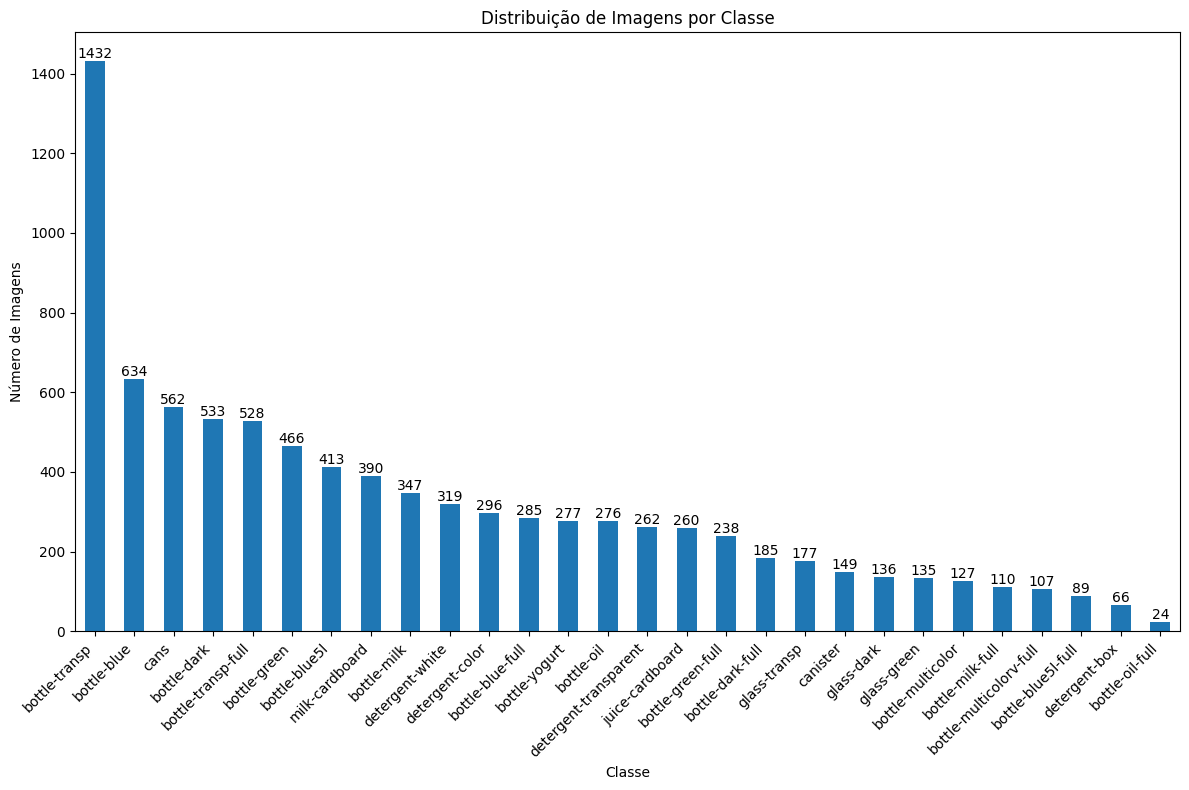

In [4]:
# Plotar gráfico da distribuição das classes:
# Gerar um gráfico de barras com a quantidade de imagens por classe.
# Avaliar se há desequilíbrio nas classes, o que pode impactar o treinamento de modelos.
import matplotlib.pyplot as plt

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'label' existe
    if 'label' not in df.columns:
        raise KeyError("A coluna 'label' não existe no DataFrame.")

    # Contar a quantidade de imagens por classe
    class_counts = df['label'].value_counts()

    # Plotar o gráfico de barras
    ax = class_counts.plot(
        kind='bar',
        title='Distribuição de Imagens por Classe',
        figsize=(12, 8)
    )

    plt.xlabel('Classe')
    plt.ylabel('Número de Imagens')
    plt.xticks(rotation=45, ha='right') # Gira os labels para melhor visualização
    plt.tight_layout() # Ajusta o layout para evitar sobreposição

    # Adicionar valores em cima das barras
    for container in ax.containers:
        ax.bar_label(container)

    plt.show()

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

In [5]:
!pip install imbalanced-learn

#### Preparação dos Dados para Oversampling:

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Verificar se o DataFrame 'df' existe e não está vazio
if 'df' not in globals() or df.empty:
    raise ValueError("O DataFrame 'df' não foi encontrado ou está vazio. Verifique se a etapa de criação do dataframe foi executada corretamente.")

# Para aplicar SMOTE, precisamos de features numéricas.
# Neste caso, como estamos lidando com imagens, o Oversampling geralmente
# é aplicado nas features extraídas das imagens (após a extração de features
# ou dentro do pipeline de treinamento).
# No entanto, para demonstrar como o SMOTE funciona em um contexto tabular
# (que seria o caso se tivéssemos features numéricas extraídas), vamos
# criar um exemplo simplificado usando apenas o índice e o label.
# NOTE: Aplicar SMOTE diretamente nos dados de imagem brutos NÃO é o usual.
# Este exemplo serve APENAS para ilustrar o uso do SMOTE com labels.

# Vamos simular features numéricas simples apenas para usar o SMOTE
# Em um fluxo real de ML com imagens, o SMOTE seria aplicado após a extração
# de features numéricas (ex: embeddings de um modelo pré-treinado)
X_dummy = pd.DataFrame(np.arange(len(df)).reshape(-1, 1), columns=['dummy_feature'])
y = df['label']

print("Iniciando o Oversampling com SMOTE...")

try:
    # Inicializar o SMOTE
    # random_state para reprodutibilidade
    smote = SMOTE(random_state=42)

    # Aplicar SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_dummy, y)

    print("Oversampling concluído.")
    print(f"Número de amostras originais: {len(y)}")
    print(f"Número de amostras após SMOTE: {len(y_resampled)}")

    # Criar um novo DataFrame com os resultados do Oversampling (apenas labels para demonstração)
    df_resampled = pd.DataFrame({'label': y_resampled})

except Exception as e:
    print(f"Ocorreu um erro durante o Oversampling com SMOTE: {e}")
    # Em caso de erro, podemos querer continuar com o DataFrame original
    df_resampled = df.copy()
    X_resampled = X_dummy.copy() # Manter X original para evitar erros subsequentes
    y_resampled = y.copy() # Manter y original para evitar erros subsequentes

Iniciando o Oversampling com SMOTE...
Oversampling concluído.
Número de amostras originais: 8823
Número de amostras após SMOTE: 40096


#### Verificação da Distribuição das Classes Após Oversampling:

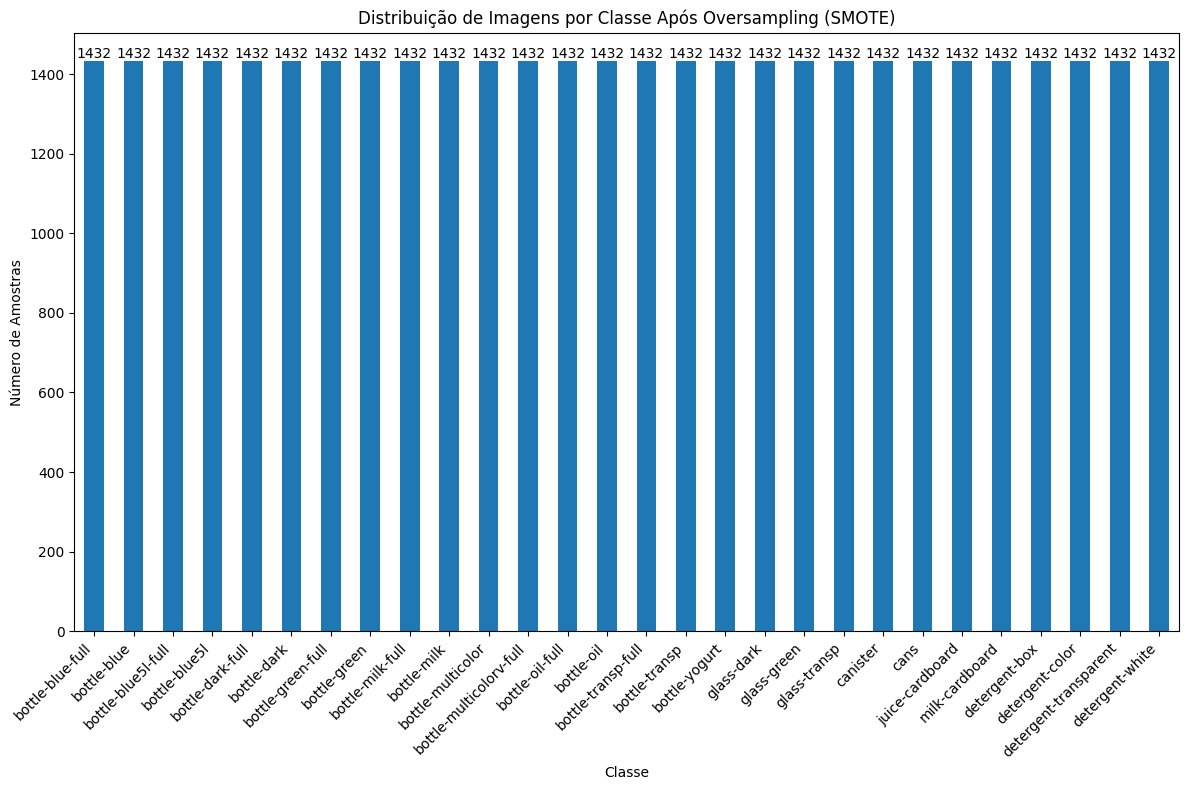

In [7]:
import matplotlib.pyplot as plt

try:
    # Verificar se o DataFrame 'df_resampled' existe e não está vazio
    if 'df_resampled' not in globals() or df_resampled.empty:
        raise ValueError("O DataFrame 'df_resampled' não foi encontrado ou está vazio.")

    # Verificar se a coluna 'label' existe
    if 'label' not in df_resampled.columns:
        raise KeyError("A coluna 'label' não existe no DataFrame 'df_resampled'.")

    # Contar a quantidade de imagens por classe no dataset rebalanceado
    class_counts_resampled = df_resampled['label'].value_counts()

    # Plotar o gráfico de barras para o dataset rebalanceado
    ax = class_counts_resampled.plot(
        kind='bar',
        title='Distribuição de Imagens por Classe Após Oversampling (SMOTE)',
        figsize=(12, 8)
    )

    plt.xlabel('Classe')
    plt.ylabel('Número de Amostras')
    plt.xticks(rotation=45, ha='right') # Gira os labels para melhor visualização
    plt.tight_layout() # Ajusta o layout para evitar sobreposição

    # Adicionar valores em cima das barras
    for container in ax.containers:
        ax.bar_label(container)

    plt.show()

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

### 7. Verificar a Presença de Duplicatas 🧠

#### Documentação da análise de duplicatas no dataset:

✔️ **Objetivo da Análise:**
- Identificar imagens duplicadas que possam enviesar os resultados dos modelos de Machine Learning.
- Verificar a presença de duplicatas tanto no conjunto de arquivos físicos quanto no arquivo de metadados.

🔧 **Metodologia Utilizada:**
- Aplicação de um **hash perceptual** `(imagehash.phash())` para cada imagem do dataset. Este método permite detectar imagens visualmente idênticas, mesmo que possuam diferenças nos nomes ou tamanhos dos arquivos.

- Verificação de:
    - Quantidade de hashes duplicados no dataframe (`df`).
    - Visualização dos registros duplicados no dataframe, caso existissem.
    - Exibição visual lado a lado das imagens duplicadas, se presentes.
    - Análise da distribuição das duplicatas por classe, caso fossem encontradas.

📊 **Resultados Obtidos:**
- Quantidade de Duplicatas: 0
- Nenhuma imagem duplicada foi identificada no dataset.
- O gráfico de duplicatas por classe não foi gerado, pois não existem duplicatas.

✅ **Conclusões:**
- O dataset está livre de duplicatas visuais perceptíveis.
- Não há necessidade de realizar ações como remoção, substituição ou tratamento de imagens duplicadas.
- Este resultado assegura que não há risco de enviesamento ou sobre-representação de exemplos que poderiam impactar negativamente o desempenho dos modelos.

🚩 **Recomendações Futuras:**
- Incluir esta verificação de duplicatas como uma etapa padrão no pipeline de validação de dados para qualquer novo dataset.

#### Quantidade de duplicatas:

In [ ]:
# Identificar imagens duplicadas que possam enviesar os resultados:

from IPython.display import display

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'image_hash' existe
    if 'image_hash' not in df.columns:
        raise KeyError("A coluna 'image_hash' não existe no DataFrame.")

    # Calcular quantidade de duplicatas
    num_duplicatas = df['image_hash'].duplicated().sum()

    print(f"Quantidade de imagens duplicadas gerada com sucesso!")
    display(num_duplicatas)

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")



#### Visualizar duplicatas:

In [ ]:
# Verificar duplicatas no arquivo de informações:


from IPython.display import display

try:
    # Verificar se o DataFrame existe
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")

    # Verificar se o DataFrame não está vazio
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'image_hash' existe
    if 'image_hash' not in df.columns:
        raise KeyError("A coluna 'image_hash' não existe no DataFrame.")

    # Filtrar imagens com hashes duplicados (mantém todas as ocorrências)
    df_duplicated = df[df['image_hash'].duplicated(keep=False)]

    # Verificar e exibir duplicatas, se houver
    if not df_duplicated.empty:
        print(f"Foram encontradas {df_duplicated.shape[0]} imagens duplicadas.")
        display(df_duplicated)
    else:
        print("Nenhuma imagem duplicada foi encontrada no dataset.")

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


#### Exibir imagens duplicadas:

In [ ]:
# Verificar duplicatas no arquivo de informações:

import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import os

try:
    # Verificações iniciais
    if 'df' not in globals() or df.empty:
        raise ValueError("O DataFrame 'df' não foi encontrado ou está vazio.")

    if 'df_duplicated' not in globals() or df_duplicated.empty:
        raise ValueError("Nenhuma imagem duplicada foi encontrada no dataset.")

    if 'image_hash' not in df.columns or 'image_path' not in df.columns:
        raise KeyError("As colunas necessárias 'image_hash' ou 'image_path' não existem no DataFrame.")

    # Criar dicionário de imagens duplicadas
    duplicated_images = {}
    for i in range(df_duplicated.shape[0]):
        hash_duplicated = df_duplicated.iloc[i]['image_hash']
        duplicated = df[df['image_hash'] == hash_duplicated]["image_path"].values
        duplicated_images[str(hash_duplicated)] = duplicated.tolist()

    # Verificar e exibir duplicatas
    if duplicated_images:
        display(duplicated_images)  # Mostrar o dicionário de duplicatas

        for hash_value, paths in duplicated_images.items():
            print(f"\nHash duplicado: {hash_value}")
            print(f"{len(paths)} imagens duplicadas encontradas:\n", paths)

            fig, axes = plt.subplots(1, len(paths), figsize=(5 * len(paths), 5))
            if len(paths) == 1:
                axes = [axes]  # Garante que seja iterável se só tiver uma imagem

            for ax, img_path in zip(axes, paths):
                if os.path.exists(img_path):
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        ax.imshow(img_rgb)
                        ax.set_title(os.path.basename(img_path))
                        ax.axis('off')
                    else:
                        ax.text(0.5, 0.5, "Imagem não pode ser carregada",
                                horizontalalignment='center',
                                verticalalignment='center')
                        ax.axis('off')
                else:
                    ax.text(0.5, 0.5, "Caminho não encontrado",
                            horizontalalignment='center',
                            verticalalignment='center')
                    ax.axis('off')

            plt.show()

    else:
        print("Nenhuma imagem duplicada foi encontrada no dataset.")

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


#### Gráficos de Duplicatas por Classe:

In [ ]:
import matplotlib.pyplot as plt

try:
    # Verifica se o DataFrame df_duplicated existe e não está vazio
    if 'df_duplicated' not in globals() or df_duplicated.empty:
        raise ValueError("Nenhuma duplicata encontrada no dataset.")

    # Verifica se a coluna 'label' existe
    if 'label' not in df_duplicated.columns:
        raise KeyError("A coluna 'label' não existe no DataFrame.")

    # Agrupar duplicatas por classe
    duplicates_by_class = df_duplicated.groupby('label').size()

    if not duplicates_by_class.empty:
        ax = duplicates_by_class.plot(
            kind='bar',
            title='Number of Duplicates per Class',
            figsize=(8, 6)
        )
        plt.xticks(rotation=45)
        for p in ax.patches:
            ax.annotate(
                str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center'
            )
        plt.show()
    else:
        print("Nenhuma duplicata encontrada. Gráfico não gerado.")

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


In [ ]:
import matplotlib.pyplot as plt

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'label' existe
    if 'label' not in df.columns:
        raise KeyError("A coluna 'label' não existe no DataFrame.")

    # Contar a quantidade de imagens por classe
    class_counts = df['label'].value_counts()

    # Plotar o gráfico de barras
    ax = class_counts.plot(
        kind='bar',
        title='Distribuição de Imagens por Classe',
        figsize=(12, 8)
    )

    plt.xlabel('Classe')
    plt.ylabel('Número de Imagens')
    plt.xticks(rotation=45, ha='right') # Gira os labels para melhor visualização
    plt.tight_layout() # Ajusta o layout para evitar sobreposição

    # Adicionar valores em cima das barras
    for container in ax.containers:
        ax.bar_label(container)

    plt.show()

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")